In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from itertools import groupby
from itertools import chain
from more_itertools import pairwise
from collections import Counter
from IPython.display import Image, display, clear_output
from ipywidgets import Button, HBox, Label, Layout, GridBox, Checkbox, ToggleButton, ToggleButtons, Dropdown, IntProgress
import math
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import networkx as nx
from random import choice
import seaborn as sns

In [2]:
df = pd.read_csv('diagram-entity-matrix.csv')
debug = False
STRATEGY = 'random' # min, max, random, max_diff, min_diff

In [3]:
def drop_diagrams(diagrams):
    for diagram in diagrams:
        try:
            unused.drop(diagram, inplace=True)
        except KeyError:
            print(f"! The {diagram} is already not in the list.")                

def use_diagram(value):    
    if debug: print(f"--> I use {value}")
    if already_modeled:
        new_key = max(already_modeled.keys()) + 1
    else:
        new_key = 1
    already_modeled[new_key] = value
    drop_diagrams([value])

In [15]:
diagram_order = pd.DataFrame(columns=['Diagram', 'i', 'Count', 'Indiv_Cov', 'Cum_Cov', 'Sim'])
# Diagram - Diagram name
# i - for displaying purposes
# Count - Number of supported entities
# Indiv_Cov - Individual diagram coverage
# Cum_Cov - Cumulative coverage
# Sim - Similarity to the previous cumulative diagrams 

already_modeled = {}
cumulative_vector = np.zeros((1, 120),dtype=int)
unused = df.transpose()[1:]
sorted_sums = unused.transpose().sum().sort_values(ascending=False)
i = 0

if STRATEGY == 'random':
  next_diagram = choice(list(sorted_sums.keys()))
elif STRATEGY == 'min_diff':
  next_diagram = sorted_sums.index[-1]
else:
  next_diagram = sorted_sums.index[0]
similarity = None

while len(sorted_sums) > 0:
  chosen_diagram = next_diagram
  count = sorted_sums[chosen_diagram]
  chosen_vector = np.array(df[chosen_diagram]).reshape(1, -1)
  cumulative_vector = cumulative_vector | chosen_vector
  cum_count = cumulative_vector.sum()   
  cum_cov = round(cum_count*100/df.shape[0])
  diagram_order.loc[i] = [chosen_diagram, i, count, round(count*100/df.shape[0]), round(cum_count*100/df.shape[0]), similarity]
  if debug: 
    print(f"{i}. {chosen_diagram} [{str(count)}] (debug mode cum_cov: {str(round(cum_count*100/df.shape[0]))}% cov: {str(round(count*100/df.shape[0]))}%, sim: {similarity}%)")    
  use_diagram(chosen_diagram)
  if unused.empty: 
    if debug: print("Empty unused")
    break
  #ch_values = (cosine_similarity(chosen_vector, unused)[0]*100).round()
  cs_values = (cosine_similarity(cumulative_vector, unused)[0]*100).round()
  # cov_values = 
  labels = dict(enumerate(unused.transpose().columns))
  ranking = dict(zip(labels.values(),cs_values))  

  count_diff = {}
  for column in unused.transpose().columns:
    col_vals = unused.transpose()
    cum_vec = pd.DataFrame(cumulative_vector).transpose()
    if debug: 
      print('col_vals')
      print(col_vals[column])
      print('cum_vec[0]')
      print(cum_vec[0])
    diff_ones = ((col_vals[column] == 1) & (col_vals[column].ne(cum_vec[0]))).sum()
    total_ones = (col_vals[column] == 1).sum()
    if debug: 
      print("diff_ones")
      print(diff_ones)
      print("total_ones")
      print(total_ones)
    count_diff[column] = (diff_ones, total_ones)
    
  sorted_diff = sorted(count_diff.items(), key=lambda x: (-x[1][0], -x[1][1]))
  if debug: 
    for column, (diff_count, total_count) in sorted_diff:
      print(f"Column: {column}, Count of different 1's: {diff_count}, Total 1's: {total_count}")

  column, (diff_count, total_count) = sorted_diff[0]
  if debug: 
    print(f"Best Column: {column}, Count of different 1's: {diff_count}, Total 1's: {total_count}")

  if STRATEGY == 'min':
    next_diagram = min(ranking, key=lambda k: ranking[k])
  elif STRATEGY == 'max': 
    next_diagram = max(ranking, key=lambda k: ranking[k])
  elif STRATEGY == 'max_diff':
    next_diagram = column
  elif STRATEGY == 'min_diff':
    next_diagram = column
  else:
    next_diagram = choice(list(ranking.keys()))
  
  similarity = ranking[next_diagram]
  if debug: print(ranking)
  i = i + 1 

In [16]:
np.trapz(diagram_order['Cum_Cov'])

1138.0

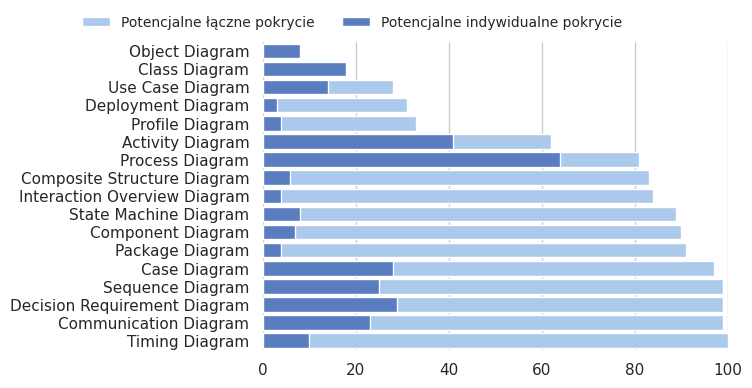

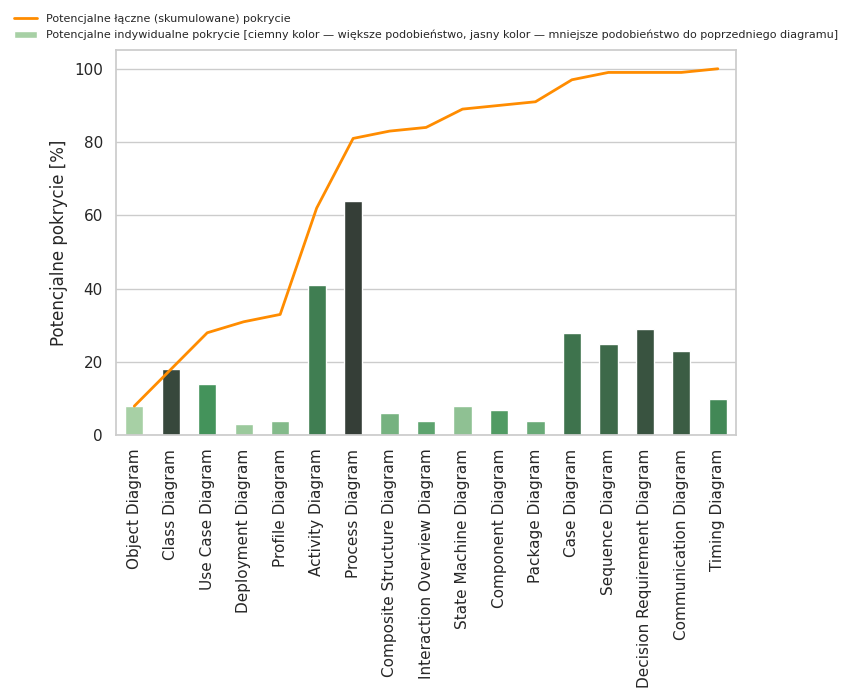

In [17]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 4),dpi=100)
data = diagram_order

sns.set_color_codes("pastel")
sns.barplot(x="Cum_Cov", y="Diagram", data=data,
            label="Potencjalne łączne pokrycie", color="b")

sns.set_color_codes("muted")
sns.barplot(x="Indiv_Cov", y="Diagram", data=data,
            label="Potencjalne indywidualne pokrycie", color="b")

ax.legend(ncol=2, loc="lower center", frameon=True)
plt.legend(title='')
sns.move_legend(
    ax, "lower right", fontsize='10', title_fontsize='10',
    bbox_to_anchor=(0.8, 1), ncol=2, frameon=False,
)
ax.set(xlim=(0, 100),  ylabel="",xlabel="")
sns.despine(left=True, bottom=True)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 5), dpi=100)

data_x = pd.DataFrame(data, data.index, columns=['Indiv_Cov','Cum_Cov','Sim'])
pal = sns.color_palette("Greens_d", len(data_x))
rank = data_x['Sim'].argsort().argsort()

sns.lineplot(x=data_x.index, y='Cum_Cov', data=data_x, linewidth=2, label='Potencjalne łączne (skumulowane) pokrycie', color="darkorange") #color='b'
ax = sns.barplot(x=data_x.index, y='Indiv_Cov', data=data_x, palette=np.array(pal)[rank], label='Potencjalne indywidualne pokrycie [ciemny kolor — większe podobieństwo, jasny kolor — mniejsze podobieństwo do poprzedniego diagramu]', width=0.5) #color='lightgreen'

ax.set_xticks(data_x.index)
xtick_labels = data['Diagram']
ax.set_xticklabels(xtick_labels, rotation=90)

ax.set_ylabel('Potencjalne pokrycie [%]')

plt.legend(title='')
sns.move_legend(
    ax, "lower center", fontsize='8', title_fontsize='8',
    bbox_to_anchor=(.5, 1), ncol=1, frameon=False,
)

plt.show(block=False)